In [2]:
import tensorflow as tf
import numpy as np
from data_aug.data_aug import *
from data_aug.bbox_util import *
import cv2 
import matplotlib.pyplot as plt 
import pickle as pkl
%matplotlib inline
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [4]:
 # common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = "/home/pan/dl_py3/pan/comp2/pascal_voc_training_data.txt"
IMAGE_DIR = "/home/pan/dl_py3/pan/comp2/VOCdevkit_train/VOC2007/JPEGImages/"

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 100

In [5]:
# 判斷是否要 data augmentation 之多個函數
def counter_for_10(object_list):
    object_strongaug_aug = sum([(i == '10') for i in object_list]) > 0
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 1
    if object_strongaug_aug and not object_no_aug:
      return  True
    else:
      return False

def counter_for_special(object_list):
    object_strongaug_aug = sum([(i == '1' or i == '10' or i == '12' or i == '13' or i == '5') for i in object_list]) > 0
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 0
    if object_strongaug_aug and not object_no_aug:
      return  True
    else:
      return False

def counter_element_strong(object_list):
    # 8,6物件(有不需要aug的)
    object_no_aug = sum([(i == '8' or i == '6' or i == '14') for i in object_list]) > 0
    if object_no_aug:
      return False
    else:
      return True

def counter_element(object_list):

    # 非14,非8,非6的物件(需要aug的為0)
    object_need_aug = sum([(i != '14' and  i != '8' and i != '6') for i in object_list]) == 0
    # 14,8,6物件(有不需要aug的)
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 0
    # 14是否過多
    object_much_14 = sum([i == '14' for i in object_list]) > 0
    # 8是否過多
    #object_much_8 = sum([i == '8' for i in object_list]) > 1
    #object_10 = sum([i == '10' for i in object_list]) < 0

    if (object_need_aug and object_need_aug) or object_much_14:
        return False
    else:
        return True
# 更新bounding變成我們要的形式 
def update_bboxes(bbox):

    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    label = bbox[4]
    
    return [xmin,ymax,xmax,ymin,label]

In [6]:
## 設定一些Goabal variables存東西

object_class = []
image_names = []
record_list = []
object_num_list = []
# filling the record_list
input_file = open(DATA_PATH, 'r')

for line in input_file:
    line = line.strip()
    ss = line.split(' ')
    image_names.append(ss[0])

    record_list.append([float(num) for num in ss[1:]])

    object_num_list.append(min(len(record_list[-1])//5, MAX_OBJECTS_PER_IMAGE))
    if len(record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
        record_list[-1] = record_list[-1] +\
        [0., 0., 0., 0., 0.]*\
        (MAX_OBJECTS_PER_IMAGE-len(record_list[-1])//5)
    elif len(record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
        record_list[-1] = record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
        
# 判斷object是什麼
for i in range(len(record_list)):
    object_class2 = []
    k = 4
    for j in range(object_num_list[i]):
        object_class2.append(str(int(record_list[i][k])))
        k += 5
    object_class.append(object_class2)
  
# 得到bounding box
bboxes_list_raw = []
for i in range(len(record_list)):
    count = 0
    bboxes = []
    for j in range(int(len(record_list[i])/5)):
        bboxes.append(record_list[i][count:count + 5])
        count += 5
    bboxes = np.array([update_bboxes(k) for k in bboxes])
    bboxes_list_raw.append(bboxes)

bboxes_list_raw = dict(zip(image_names,bboxes_list_raw))
    
# aug name(為了平衡資料)
aug_names = []

for i in range(int(len(object_class))):
    if counter_for_10(object_class[i]):
        for j in range(20):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_for_special(object_class[i]) == True:
        for j in range(15):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_element_strong(object_class[i]) == True:
        for j in range(10):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_element(object_class[i]) == True:
        for j in range(4):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    else:
        aug_names.append("aug" + "_" + '0' + "_" + image_names[i])

# Random parameter setting
np.random.seed(77)
# HSV
H = np.random.randint(60,size = len(aug_names))
S = np.random.randint(60,size = len(aug_names))
V = np.random.randint(60,size = len(aug_names))

# HorizontalFlip
flip = np.random.binomial(1, 0.5, len(aug_names))
# Scale
scale1 = np.random.uniform(-0.08,0.08,len(aug_names))
scale2 = np.random.uniform(-0.08,0.08,len(aug_names))
# Shear
shear = np.random.uniform(-0.08,0.08,len(aug_names))
# Rotation
#rotate = np.random.uniform(-5,5,len(aug_names))
random_parameter = dict(zip(aug_names,list(zip(H,S,V,flip,scale1,scale2,shear))))


image_object_dict = dict(zip(image_names,object_num_list))

### In this cell, we use the map function of tensorfor2.0 in our dataset. Then, we can parallel computing in data preprocess

In [7]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline ready to be fed into a model.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self,object_class,image_names,object_num_list):
        self.object_class = object_class
        self.image_names = image_names
        self.object_num_list = object_num_list

    def _data_preprocess(self, image_name):
        
        aug_name_list = [bytes.decode(s) for s in tf.strings.split(image_name, sep='_').numpy()]
        object_num = image_object_dict.get(aug_name_list[2])

        #若為０則生成原圖
        if aug_name_list[1] == "0":
            path = IMAGE_DIR +''+ aug_name_list[2]
            img_file = tf.io.read_file(path)
            img = tf.io.decode_jpeg(img_file, channels=3)
            bboxes = bboxes_list_raw.get(aug_name_list[2])
            
            
        # 否則生成變化圖
        else:
            parameter = random_parameter.get(aug_name_list[0] +'_'+ aug_name_list[1] +'_'+ aug_name_list[2])
            path = IMAGE_DIR +''+ aug_name_list[2]
            img_file = tf.io.read_file(path)
            img = tf.io.decode_jpeg(img_file, channels=3)
            
            bboxes = bboxes_list_raw.get(aug_name_list[2])
            seq = Sequence([RandomHSV((parameter[0],parameter[0]), (parameter[1],parameter[1]), (parameter[2],parameter[2])),
                            RandomHorizontalFlip(parameter[3]), Scale(parameter[4],parameter[5]), Shear(parameter[6])])
            img, bboxes = seq(img.numpy().copy(), bboxes.copy())
            
        if bboxes.shape[0] != 20:
            bboxes = np.concatenate([bboxes,np.zeros((20 - bboxes.shape[0] ,5))],axis = 0)


        # map function
        h = tf.shape(img)[0]
        w = tf.shape(img)[1]
        
        width_rate = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_rate = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 
        
        
        image = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
        noise = tf.random.normal(image.shape,stddev=15)
        image = tf.keras.applications.vgg16.preprocess_input(image)
        image = tf.math.add(image,noise)
        
        raw_labels = tf.cast(bboxes, tf.float32)
        
        xmin = raw_labels.numpy()[:, 0]
        xmin[xmin > w.numpy()] = w.numpy()
        
        ymax = raw_labels.numpy()[:, 1]
        ymax[ymax > h.numpy()] = h.numpy()
        
        xmax = raw_labels.numpy()[:, 2]
        xmax[xmax > w.numpy()] = w.numpy()
        
        ymin = raw_labels.numpy()[:, 3]
        ymin[ymin > h.numpy()] = h.numpy()
        
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate

        box_w = (xmax - xmin) * width_rate
        box_h = (ymax - ymin) * height_rate
        
        # BBOXES做修正，以免BBOXES超出邊界。
        
        condition1 =  (np.any(xcenter.numpy()[:object_num] > 447.5) + np.any(ycenter.numpy()[:object_num] > 447.5)) > 0
        condition2 =  (np.any(box_w.numpy()[:object_num] < 0.5) + np.any((box_h.numpy()[:object_num] < 0.5).sum())) > 0
        condition3 =  np.any((xcenter - box_w/2) < 0)
        condition4 =  np.any((ycenter - box_h/2) < 0)
        condition5 =  np.any((xcenter + box_w/2) > 500)
        condition6 =  np.any((ycenter + box_h/2) > 500)
        
        if (condition1 + condition2 + condition3 + condition4 + condition5 + condition6) > 0:
            img_file = tf.io.read_file(path)
            img = tf.io.decode_jpeg(img_file, channels=3)
            bboxes = bboxes_list_raw.get(aug_name_list[2])
            seq2 = Sequence([RandomHSV((parameter[0],parameter[0]), (parameter[1],parameter[1]), (parameter[2],parameter[2])),RandomHorizontalFlip(parameter[3])])
            img, bboxes = seq2(img.numpy().copy(), bboxes.copy())
            
            if bboxes.shape[0] != 20:
                bboxes = np.concatenate([bboxes,np.zeros((20 - bboxes.shape[0] ,5))],axis = 0)
            
            # map function
            h = tf.shape(img)[0]
            w = tf.shape(img)[1]

            width_rate = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
            height_rate = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

            image = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
            image = tf.keras.applications.vgg16.preprocess_input(image) # 跟著pretrain做調整

            raw_labels = tf.cast(bboxes, tf.float32)

            xmin = raw_labels.numpy()[:, 0]
            xmin[xmin > w.numpy()] = w.numpy()

            ymax = raw_labels.numpy()[:, 1]
            ymax[ymax > h.numpy()] = h.numpy()

            xmax = raw_labels.numpy()[:, 2]
            xmax[xmax > w.numpy()] = w.numpy()

            ymin = raw_labels.numpy()[:, 3]
            ymin[ymin > h.numpy()] = h.numpy()

            class_num = raw_labels[:, 4]

            xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
            ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate

            box_w = (xmax - xmin) * width_rate
            box_h = (ymax - ymin) * height_rate

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)        
        
        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices(self.image_names)
        dataset = dataset.map(lambda x: tf.py_function(func = self._data_preprocess,inp = [x],Tout = [tf.float32,tf.float32,tf.int32]), num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(2000)
        dataset = dataset.batch(BATCH_SIZE)

        return dataset

In [8]:
pre_trained_model = tf.keras.applications.ResNet152(include_top=False, weights='imagenet',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
pre_trained_model.trainable=False

In [9]:
img_inputs = keras.models.Sequential()

img_inputs.add(layers.Conv2D(1024,3,strides=1,kernel_regularizer = tf.keras.regularizers.l2(0.0005)))
img_inputs.add(layers.LeakyReLU(0.1))
img_inputs.add(layers.Conv2D(1024,3,strides=2,kernel_regularizer = tf.keras.regularizers.l2(0.0005)))
img_inputs.add(layers.LeakyReLU(0.1))


img_inputs.add(layers.Flatten())
img_inputs.add(layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))
img_inputs.add(layers.Dropout(0.5))
img_inputs.add(layers.Dense(1024, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))
img_inputs.add(layers.LeakyReLU(0.1))
img_inputs.add(layers.Dense(CELL_SIZE*CELL_SIZE*(BOXES_PER_CELL*5+20),
                            activation='relu', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01)))

YOLO = keras.Model(inputs=pre_trained_model.input, outputs=img_inputs(pre_trained_model.output), name="YOLO")

In [10]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

#for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.tile(np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4]), [1, 1, BOXES_PER_CELL, 1])

In [11]:
def yolo_loss(predicts, labels, objects_num):
    """
    calculate loss
    Args:
        predict: 3-D tensor [cell_size, cell_size, 5 * boxes_per_cell]
        labels : [max_objects, 5]  (x_center, y_center, w, h, class)
    """
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    batch_size = predicts.shape[0]
    loss = 0.

    for i in tf.range(batch_size):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

In [12]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #calculate objects tensor [CELL_SIZE, CELL_SIZE]
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)

    temp = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    objects = tf.ones(temp, tf.float32)

    temp = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    temp = tf.reshape(temp, (2, 2))
    objects = tf.pad(objects, temp, "CONSTANT")

    #calculate objects  tensor [CELL_SIZE, CELL_SIZE]
    #calculate responsible tensor [CELL_SIZE, CELL_SIZE]
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    temp = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                   tf.int32)
#     tmp = tf.stack([center_y, CELL_SIZE - center_y - 1,
#                     center_x, CELL_SIZE - center_x - 1])
    temp = tf.reshape(temp, (2, 2))
    response = tf.pad(response, temp, "CONSTANT")
    #objects = response

    #calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])

    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])
    #calculate C [cell_size, cell_size, boxes_per_cell]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    max_I = tf.reduce_max(I, 2, keepdims=True)

    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    #p_sqrt_w = tf.sqrt(tf.abs(predict_boxes[:, :, :, 2])) * ((tf.cast(predict_boxes[:, :, :, 2] > 0, tf.float32) * 2) - 1)
    #p_sqrt_h = tf.sqrt(tf.abs(predict_boxes[:, :, :, 3])) * ((tf.cast(predict_boxes[:, :, :, 3] > 0, tf.float32) * 2) - 1)
    #p_sqrt_w = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 2]))
    #p_sqrt_h = tf.sqrt(tf.maximum(0.0, predict_boxes[:, :, :, 3]))
    #p_sqrt_w = predict_boxes[:, :, :, 2]
    #p_sqrt_h = predict_boxes[:, :, :, 3]
    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predict p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(objects, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE
    #class_loss = tf.nn.l2_loss(tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE
    #object_loss = tf.nn.l2_loss(I * (p_C - (C + 1.0)/2.0)) * OBJECT_SCALE

    #noobject_loss
    #noobject_loss = tf.nn.l2_loss(no_I * (p_C - C)) * NOOBJECT_SCALE
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                 tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                 tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                 tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [13]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [14]:
CKT_Dir = "./ckpts/YOLO_ResNet152_normal_noise_fastaug"
checkpoint_name = 'YOLO_ResNet152_normal_noise_fastaug'

last_ckp = tf.train.latest_checkpoint(CKT_Dir)
if last_ckp:
    ckpt = tf.train.Checkpoint(net=YOLO)
    ckpt.restore(last_ckp)
    init_epoch = int(last_ckp.split("-")[-1])+1
    print(f'Resume training from epoch {init_epoch-1}')
else:
    init_epoch=1

Resume training from epoch 101


In [15]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(init_epoch-1), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, CKT_Dir, max_to_keep=3,
                                     checkpoint_name=checkpoint_name)

In [16]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        n1 = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        n2 = n1 + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:n1], (-1, CELL_SIZE, CELL_SIZE, 20))
        scales = tf.reshape(outputs[:, n1:n2], (-1, CELL_SIZE, CELL_SIZE, 2))
        boxes = tf.reshape(outputs[:, n2:], (-1, CELL_SIZE, CELL_SIZE, 2*4))
        predicts = tf.concat([class_probs, scales, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [17]:
dataset = DatasetGenerator(object_class,aug_names,object_num_list).generate()

In [19]:
from datetime import datetime
print("{}, start training.".format(datetime.now()))
for i in range(init_epoch,EPOCHS+1):
    print("Epoch: %d/%d" % (i,EPOCHS))
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        if idx % 1000 == 0:
            print(idx)
            
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i, train_loss_metric.result()))

    save_path = manager.save(checkpoint_number=tf.Variable(ckpt.epoch))
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))    

2019-12-05 22:04:28.149013, start training.
Epoch: 1/100
0


/home/pan/dl_py3/momo/Competition/2/data_aug/bbox_util.py:82: RuntimeWarning: invalid value encountered in true_divide
  delta_area = ((ar_ - bbox_area(bbox))/ar_)
/home/pan/dl_py3/momo/Competition/2/data_aug/bbox_util.py:84: RuntimeWarning: invalid value encountered in less
  mask = (delta_area < (1 - alpha)).astype(int)


1000
2000
3000
2019-12-05 22:20:05.125939, Epoch 1: loss 9.85
Saved checkpoint for epoch 2: ./ckpts/YOLO_ResNet152_normal_noise_fastaug/YOLO_ResNet152_normal_noise_fastaug-2
Epoch: 2/100


/home/pan/dl_py3/momo/Competition/2/data_aug/bbox_util.py:82: RuntimeWarning: invalid value encountered in true_divide
  delta_area = ((ar_ - bbox_area(bbox))/ar_)
/home/pan/dl_py3/momo/Competition/2/data_aug/bbox_util.py:84: RuntimeWarning: invalid value encountered in less
  mask = (delta_area < (1 - alpha)).astype(int)


0
1000
2000
3000
2019-12-05 22:35:26.988112, Epoch 2: loss 6.82
Saved checkpoint for epoch 3: ./ckpts/YOLO_ResNet152_normal_noise_fastaug/YOLO_ResNet152_normal_noise_fastaug-3
Epoch: 3/100
0
1000
2000
3000
2019-12-05 22:50:47.868051, Epoch 3: loss 6.20
Saved checkpoint for epoch 4: ./ckpts/YOLO_ResNet152_normal_noise_fastaug/YOLO_ResNet152_normal_noise_fastaug-4
Epoch: 4/100
0
1000
2000
3000
2019-12-05 23:06:08.500473, Epoch 4: loss 5.94
Saved checkpoint for epoch 5: ./ckpts/YOLO_ResNet152_normal_noise_fastaug/YOLO_ResNet152_normal_noise_fastaug-5
Epoch: 5/100
0
1000
2000
3000
2019-12-05 23:21:29.065644, Epoch 5: loss 5.73
Saved checkpoint for epoch 6: ./ckpts/YOLO_ResNet152_normal_noise_fastaug/YOLO_ResNet152_normal_noise_fastaug-6
Epoch: 6/100
0
1000
2000
3000
2019-12-05 23:36:51.053936, Epoch 6: loss 5.57
Saved checkpoint for epoch 7: ./ckpts/YOLO_ResNet152_normal_noise_fastaug/YOLO_ResNet152_normal_noise_fastaug-7
Epoch: 7/100
0
1000
2000
3000
2019-12-05 23:52:11.877276, Epoch 7: l

In [18]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    n1 = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    n2 = n1 + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:n1], (-1, CELL_SIZE, CELL_SIZE, 20))
    scales = np.reshape(outputs[:, n1:n2], (-1, CELL_SIZE, CELL_SIZE, 2))
    boxes = np.reshape(outputs[:, n2:], (-1, CELL_SIZE, CELL_SIZE, 2*4))
    predicts = np.concatenate([class_probs, scales, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]
    #print P[5,1, 0, :]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf


import tensorflow.keras.backend as K

def process_outputs3(outputs,score_threshold,iou_threshold):
    """
    Process YOLO outputs into bou
    """
    n1 = CELL_SIZE * CELL_SIZE * NUM_CLASSES#7*7*20
    n2 = n1 + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL#7*7*2
    class_probs = np.reshape(outputs[:, 0:n1], (-1, 7, 7, 20))#每cell 20類機率
    scales = np.reshape(outputs[:, n1:n2], (-1, 7, 7, 2))
    boxes1 = np.reshape(outputs[:, n2:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, scales, boxes1], 3)
    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]
    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))#prob class
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))#confidence
    coordinate = np.reshape(coordinate,(CELL_SIZE,CELL_SIZE,BOXES_PER_CELL,4))#
    ######處理座標
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(CELL_SIZE), [CELL_SIZE]), ( CELL_SIZE, CELL_SIZE, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (1,0,2,3))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [ 1, 1, 2, 1])
    pred_xy=(coordinate[:,:,:,0:2]+coords)* (IMAGE_SIZE/float(CELL_SIZE))
    pred_wh = coordinate[:,:,:,2:4]* IMAGE_SIZE
    box_xy1 =pred_xy-0.5*pred_wh
    box_xy2 =pred_xy+0.5*pred_wh
    boxes=np.concatenate([box_xy1, box_xy2], axis=-1)
    ################    
    #######score
    P = C * p_classes#  class|confidence
    #P's shape [7, 7, 2, 20]
    #print P[5,1, 0, :]
    #choose the most confidence one
    box_classes = np.argmax(P, axis=-1)
    box_class_scores = np.max(P, axis=-1)
    prediction_mask = box_class_scores >= score_threshold
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)
    # Non Max Supression
    selected_idx = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, selected_idx)
    scores = K.gather(scores, selected_idx)
    classes = K.gather(classes, selected_idx)
    return(boxes,classes,scores)

def set_bound(x):
    if (x>IMAGE_SIZE):
        return(IMAGE_SIZE)
    elif(x<0):
        return(0)
    else:
        return(x)

In [19]:
test_img_files = open('/home/pan/dl_py3/pan/comp2/pascal_voc_testing_data.txt')
test_img_dir = '/home/pan/dl_py3/pan/comp2/VOCdevkit_test/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_images = test_images
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]
    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.vgg16.preprocess_input(image)

    return image_name, image, h, w

In [20]:
test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32) 

In [21]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore(CKT_Dir+"/"+checkpoint_name+"-"+str(EPOCHS))

In [23]:
@tf.function
def prediction_step(img):
    return YOLO(img)

In [24]:
output_file = open('./test_prediction.txt', 'w')
score = 0.0001
iou_threshold = 0.2
for i in range(16):
    print(i)
    #output_file = open('/content/drive/My Drive/new/pascal_voc_testing_data.txt', 'a+')
    for img_name, test_img, img_h, img_w in test_dataset.skip(i*500).take(500):
        batch_num = img_name.shape[0]
        for i in range(batch_num):
            boxes, classe,scores = process_outputs3(prediction_step(test_img[i:i+1]),score,iou_threshold)
            output = img_name[i:i+1].numpy()[0].decode('ascii')
            if len(boxes) == 0 :
               xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
               xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)                             #class取0可能不好
               output = output+" %d %d %d %d %d %f" %(xmin, ymin, xmax, ymax, class_num, conf)
            #model train不好的措施
            else:
                for j in range((len(boxes))):
                    xmin = set_bound(boxes[j,0])*tf.cast((img_w[i:i+1]/IMAGE_SIZE), dtype=tf.float32)
                    ymin = set_bound(boxes[j,1])*tf.cast((img_h[i:i+1]/IMAGE_SIZE), dtype=tf.float32)
                    xmax = set_bound(boxes[j,2])*tf.cast((img_w[i:i+1]/IMAGE_SIZE), dtype=tf.float32)
                    ymax = set_bound(boxes[j,3])*tf.cast((img_h[i:i+1]/IMAGE_SIZE), dtype=tf.float32)
                    output = output+" %d %d %d %d %d %f" %(xmin, ymin, xmax, ymax, classe[j], scores[j])
            #img filename, xmin, ymin, xmax, ymax, class, confidence
            output_file.write(output+'\n')
    #output_file.close()
output_file.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


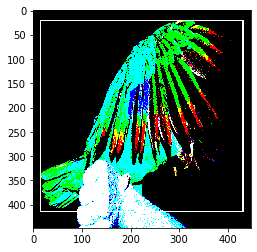

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


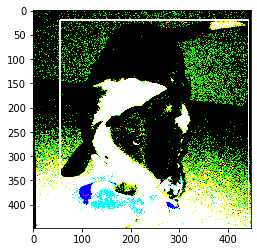

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


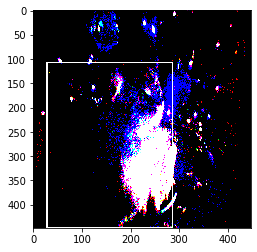

3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


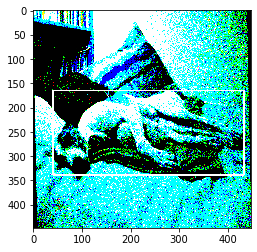

4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


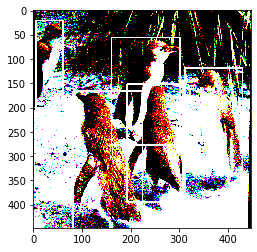

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5


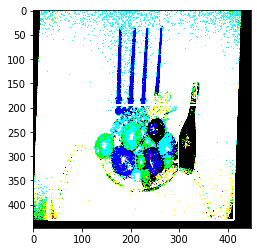

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


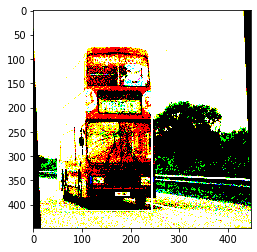

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7


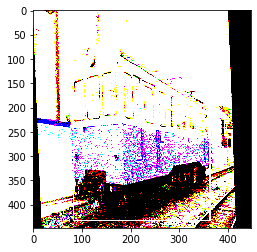

8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


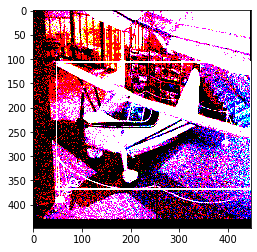

9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


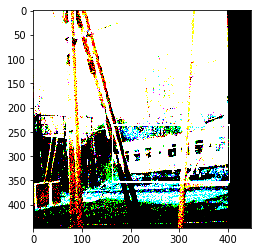

10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


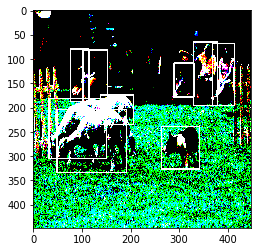

In [34]:
for idx, (image, labels, objects_num) in enumerate(dataset):
    if idx > 10:
        break
        
    print(idx)
    x,y,z = image, labels, objects_num

    label = y.numpy()[0,0:z.numpy()[0],:]
    min_x = (label[:,0] - (label[:,2] / 2))
    max_x = (label[:,0] + (label[:,2] / 2))
    min_y = (label[:,1] - (label[:,3] / 2))
    max_y = (label[:,1] + (label[:,3] / 2))
    yy = np.column_stack((min_x,max_y,max_x,min_y))
    plot_img = draw_rect(x.numpy()[0,:,:,:],yy)
    plt.imshow(plot_img)
    plt.show()
    #train_step(image,labels,objects_num)